# Практическое задание 1
## Основы обучения нейронных сетей

Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. 

Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

#### Решение
Посмотрим на изменение ошибки при изменении начальных весов.

Количество итераций ограничим минимальным размером ошибки `min_err_diff`. То есть, если ошибка практически перестанет изменяться, то можно остановить процесс.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

from sklearn import datasets
from sklearn.model_selection import train_test_split

### Функции обучения

In [2]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

### Формирование данных

Используем встроенный в библиотеку датасет

In [3]:
raw_data = datasets.load_iris()

df = pd.DataFrame(raw_data['data'], columns=raw_data['feature_names'])
df['target'] = raw_data['target']

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
X = np.array(df[raw_data['feature_names']])
y = np.array(df['target'])

#### Преобразование данных

In [6]:
X = normalize(X)
y = to_one_hot(y)

#### Разделение данных на тренировочные и тестовые

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

#### Обученние нейронной сети

In [8]:
def neural_network(learning_rate=1e-1, n_neurons=5, random_state=42):
    # присваивание случайных весов
    np.random.seed(random_state) 
    w0 = 2 * np.random.random((4, n_neurons)) - 1  # для входного слоя   - 4 входа, n_neurons выходов
    w1 = 2 * np.random.random((n_neurons, 3)) - 1  # для внутреннего слоя - n_neurons входов, 3 выхода

    # максимальное число итераций
    n_iter = 1e7

    # минимальное изменение ошибки
    min_err_diff = 1e-12

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    error = np.inf  # Изначальную ошибку примем за бесконечно большую величину
    for _ in range(int(n_iter)):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(layer0 @ w0)
        layer2 = sigmoid(layer1 @ w1)

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta @ w1.T
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T @ layer2_delta * learning_rate
        w0 += layer0.T @ layer1_delta * learning_rate

        # Новую ошибку сравниваем со старой. Если разница меньше заданного min_err_diff, то останавливаем процесс
        error_new = np.mean(np.abs(layer2_error))
        errors.append(error_new)
        if np.abs(error - error_new) < min_err_diff:
            break
        error = error_new

    accuracy = (1 - error) * 100
    return accuracy

#### Подбор параметров
Перебираем значения скорости обучения и числа нейронов на скрытом слое.

In [9]:
learning_rates_list = [1e-3, 3e-3, 1e-2, 3e-2, .1]

In [10]:
n_neurons_list = [4, 5, 6, 7]

In [11]:
%%time
import itertools
from tqdm import tqdm

results = pd.DataFrame(
    np.zeros((len(learning_rates_list), len(n_neurons_list))), 
    index=learning_rates_list, 
    columns=n_neurons_list)

for learning_rate, n_neurons in tqdm(list(itertools.product(learning_rates_list, 
                                                            n_neurons_list))):
    results.loc[learning_rate][n_neurons] = neural_network(learning_rate, n_neurons)

100%|██████████| 20/20 [27:48<00:00, 83.44s/it]

CPU times: user 27min 38s, sys: 9.13 s, total: 27min 47s
Wall time: 27min 48s


In [16]:
results

,4,5,6,7
0.001,97.732695,97.041693,97.764525,97.548279
0.003,97.732405,97.255103,97.764559,97.283701
0.010,97.534840,97.255062,97.764694,97.322851
0.030,97.084580,97.254891,97.765209,97.322805
0.100,97.083917,97.253367,97.041266,97.324955


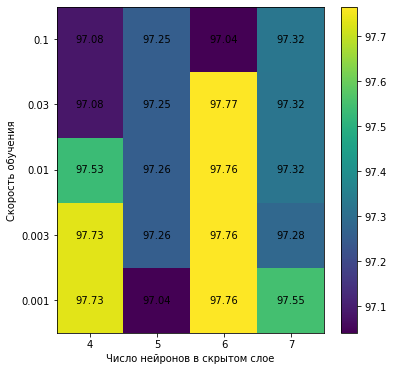

In [28]:
fig = plt.figure(figsize=(6, 6))
heatmap = plt.pcolor(results)
plt.yticks(np.arange(0.5, len(learning_rates_list), 1), learning_rates_list)
plt.xticks(np.arange(0.5, len(n_neurons_list), 1), n_neurons_list)

for y, x in itertools.product(np.arange(len(learning_rates_list)), np.arange(len(n_neurons_list))):
    plt.text(
        x + 0.5, 
        y + 0.5, 
        f'{results.iloc[y, x]:.2f}',
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('Число нейронов в скрытом слое')
plt.ylabel('Скорость обучения')

plt.colorbar(heatmap)
plt.show()

#### Выводы


Наблюдаем незначительные изменения точности.

При увеличении шага обучения, обучение происходит быстрее, но с меньшей точностью.

Но мы сделали раннюю остановку, чтобы не проходить по всем шагам, при отсутствии изменения точности.

Видим, что модель обучается по-разному для разного числа нейронов в скрытом слое.
Если судить по нашему опыту, то лучше подойдет иметь 6 нейронов в скрытом слое.